In [19]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from bayes_opt import BayesianOptimization

from tqdm import tqdm

In [20]:
data = pd.read_csv("./scraped_data/elo_pfr_betting_data.csv")
print(len(data.columns))
for c in data.columns:
    print(c)

94
Unnamed: 0.1
Unnamed: 0
date
season
neutral
playoff
team1
team2
elo1_pre
elo2_pre
elo_prob1
elo_prob2
elo1_post
elo2_post
qbelo1_pre
qbelo2_pre
qb1
qb2
qb1_value_pre
qb2_value_pre
qb1_adj
qb2_adj
qbelo_prob1
qbelo_prob2
qb1_game_value
qb2_game_value
qb1_value_post
qb2_value_post
qbelo1_post
qbelo2_post
score1
score2
quality
importance
total_rating
year
spread
spread_result
ou_line
ou_result
home_pts_def
home_pass_cmp
home_pass_att
home_pass_yds
home_pass_td
home_pass_int
home_pass_sacked
home_pass_sacked_yds
home_pass_yds_per_att
home_pass_net_yds_per_att
home_pass_cmp_perc
home_pass_rating
home_rush_att
home_rush_yds
home_rush_yds_per_att
home_rush_td
home_fgm
home_fga
home_xpm
home_xpa
home_punt
home_punt_yds
home_third_down_success
home_third_down_att
home_fourth_down_success
home_fourth_down_att
home_time_of_poss
away_pts_def
away_pass_cmp
away_pass_att
away_pass_yds
away_pass_td
away_pass_int
away_pass_sacked
away_pass_sacked_yds
away_pass_yds_per_att
away_pass_net_yds_per_att


## Preprocess Data

In [50]:
X_data = data[['qbelo1_pre', 'qbelo2_pre', 'qb1_value_pre', 'qb2_value_pre']].values
y_gt = data['ou_result'].values[:,np.newaxis]
print(np.unique(y_gt))
enc = OneHotEncoder().fit(y_gt)
y_data = enc.transform(y_gt).toarray()
mask = y_data[:,1] == 0

X_data = X_data[mask]
y_data = y_data[mask][:,0::2]
print(y_data)

['O' 'P' 'U']
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [51]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

X_train = (X_train - X_mean)/X_std
X_val = (X_val - X_mean)/X_std
X_test = (X_test - X_mean)/X_std

## EDA

(array(['O', 'P', 'U'], dtype=object), array([1564,   45, 1588]))


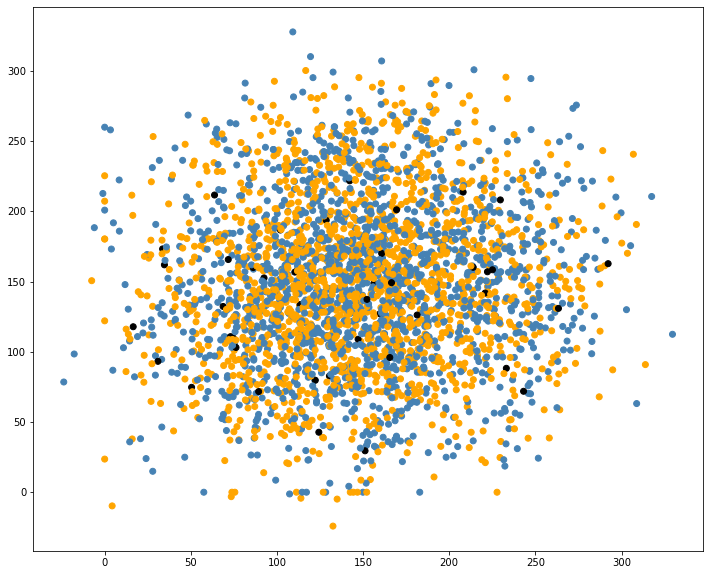

In [52]:
fig, ax = plt.subplots(figsize=(12,10))
colors = np.array(['steelblue', 'orange', 'black'])
print(np.unique(data['ou_result'], return_counts=True))
data['ou_enc'] = data['ou_result'].apply(lambda x: 0 if(x=='O') else 1 if(x=='U') else 2)
ax.scatter(data['qb1_value_pre'], data['qb2_value_pre'], color=colors[data['ou_enc'].values])
plt.show()

## GP Classifier

In [60]:
model = GaussianProcessClassifier(kernel=RBF(0.05))
model = model.fit(X_train, y_train[:,1])
print(model.score(X_train, y_train[:,1]))
print(model.score(X_val, y_val[:,1]))
print(model.score(X_test, y_test[:,1]))

1.0
0.500990099009901
0.4548335974643423


## NN BAYBAY

In [61]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.optim import Adam

from torch.utils.data import DataLoader, Dataset

In [62]:
class GameDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

In [63]:
def evaluate(model, loader):
    num_correct = 0
    total_num = 0
    model.eval()
    with torch.no_grad():
        for bn, (dx, dy) in enumerate(loader):
            pred = model(dx).detach()
            pred = np.argmax(pred, axis=1).numpy()
            true = np.argmax(dy, axis=1).numpy()
            num_correct += sum(pred == true)
            total_num += len(true)
        
    return num_correct/total_num

In [64]:
model = nn.Sequential(
    nn.Linear(6, 64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, 3),
    nn.Softmax(dim=1)
).double()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [65]:
X_data = data[['qbelo1_pre', 'qbelo2_pre', 'qb1_value_pre', 'qb2_value_pre', 'elo1_pre', 'elo2_pre', 'home_y', 'home_pass_td', 'away_pass_td', '']].values
y_gt = data['ou_result'].values[:,np.newaxis]
enc = OneHotEncoder().fit(y_gt)
y_data = enc.transform(y_gt).toarray()

X_trainval, X_test, y_trainval, y_test = train_test_split(X_data, y_data, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

X_train = (X_train - X_mean)/X_std
X_val = (X_val - X_mean)/X_std
X_test = (X_test - X_mean)/X_std

train_set = DataLoader(GameDataset(X_train, y_train), batch_size=8)
valid_set = DataLoader(GameDataset(X_val, y_val), batch_size=8)
test_set = DataLoader(GameDataset(X_test, y_test), batch_size=8)

In [ ]:
losses = []
train_accuracies = []
val_accuracies = []
for i in tqdm(range(2000)):
    total_loss = 0
    model.train()
    for bn, (dx, dy) in enumerate(train_set):
        pred = model(dx)
        
        loss = criterion(dy, pred)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses.append(total_loss/bn)
    val_accuracies.append(evaluate(model, valid_set))
    train_accuracies.append(evaluate(model, train_set))

 35%|█████████████████████▌                                       | 705/2000 [01:32<02:49,  7.64it/s]

TEST ACCURACY: 0.4640625


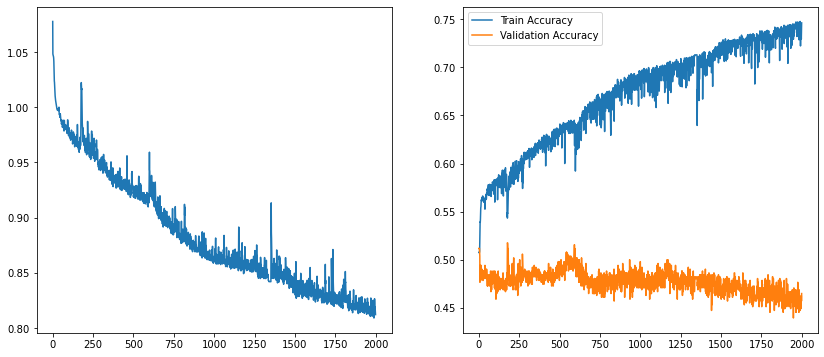

In [334]:
print("TEST ACCURACY: {}".format(evaluate(model, test_set)))
fig, ax = plt.subplots(figsize=(14,6), ncols=2)
ax[0].plot(losses)
ax[1].plot(train_accuracies, label="Train Accuracy")
ax[1].plot(val_accuracies, label="Validation Accuracy")
ax[1].legend(loc='best')
plt.show()